In [1]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Sampler
import yaml
import argparse
import re
import gc

import torch
from torch import nn
from thinker import util
from thinker.core.file_writer import FileWriter
from thinker.core.module import ResBlock
from detect_train import CustomDataset, ChunkSampler

class Decoder(nn.Module):
    def __init__(
        self,
        decoder_depth,
        input_shape
    ):
        super(Decoder, self).__init__()
        self.input_shape = input_shape        
        self.decoder_depth = decoder_depth

        frame_channels, h, w = input_shape
        out_channels = 64
        n_block = 1

        d_conv = [
            ResBlock(inplanes=out_channels * 2, disable_bn=False)
            for _ in range(n_block)
        ]
        kernel_sizes = [4, 4, 4, 4]
        conv_channels = [
            frame_channels,
            out_channels,
            out_channels * 2,
            out_channels * 2,
            out_channels * 2,
        ]
        for i in range(self.decoder_depth, 4):
            if i in [1, 3]:
                d_conv.extend(
                    [ResBlock(inplanes=conv_channels[4 - i], disable_bn=False) for _ in range(n_block)]
                )
            d_conv.append(nn.ReLU())
            d_conv.append(
                nn.ConvTranspose2d(
                    conv_channels[4 - i],
                    conv_channels[4 - i - 1],
                    kernel_size=kernel_sizes[i],
                    stride=2,
                    padding=1,
                )
            )            
        self.d_conv = nn.Sequential(*d_conv)   

    def forward(self, x):
        return self.d_conv(x)

decoder_xpid = "v18_thinker_decd2b-dec-0/test_3"

decoder_path = "../data/decode_log"
decoder_ckp_path = os.path.join(decoder_path, decoder_xpid, "ckp_detect_best.tar")
decoder_ckp_path = os.path.abspath(os.path.expanduser(decoder_ckp_path))

decoder = Decoder(decoder_depth=2, input_shape=(3,80,80))
decoder.train(False)
checkpoint = torch.load(decoder_ckp_path)
decoder.load_state_dict(checkpoint['net_state_dict'])

<All keys matched successfully>

In [2]:
from thinker.main import Env
from thinker.util import init_env_out, create_env_out
from thinker.actor_net import ActorNet
import thinker.util as util
import os
import torch

xpid = "v18_thinker_decd2b"
savedir = "/home/scuk/RS/thinker/logs/thinker/"
env_n = 8
seed = 1

ckpdir = os.path.join(savedir, xpid) 
config_path = os.path.join(ckpdir, 'config_c.yaml')
flags = util.create_flags(config_path, save_flags=False)
env = Env(
    name=flags.name,
    env_n=env_n,
    base_seed=seed,        
    gpu=False,
    train_model=False,
    parallel=False,
    savedir=savedir,        
    xpid=xpid,
    ckp=True,
    return_x=True
    )

device = env.device

actor_net = ActorNet(obs_space=env.observation_space, action_space=env.action_space, flags=flags, tree_rep_meaning=env.get_tree_rep_meaning())
checkpoint = torch.load(os.path.join(savedir, xpid, "ckp_actor.tar"))["actor_net_state_dict"]
actor_net.load_state_dict(checkpoint)
actor_net = actor_net.to(device)

env.seed(list(range(env_n)))
state = env.reset()
env_out = init_env_out(state, flags=flags, dim_actions=actor_net.dim_actions, tuple_action=actor_net.tuple_action)  
actor_state = actor_net.initial_state(batch_size=env.env_n, device=device)

Initializing env 0 with device cpu
Init. environment with obs space Box(0, 255, (3, 80, 80), uint8) and action space Discrete(5)
Model network size: 6428938


Loaded config from /home/scuk/RS/thinker/logs/thinker/v18_thinker_decd2b/config_c.yaml


Loaded model net from /home/scuk/RS/thinker/logs/thinker/v18_thinker_decd2b/ckp_model.tar


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


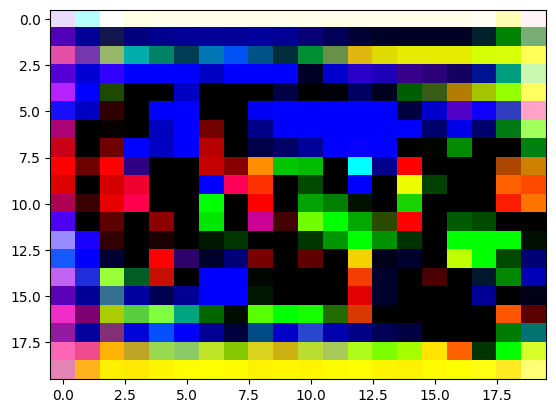

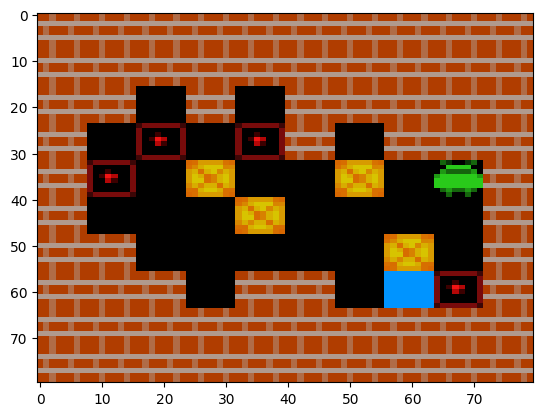

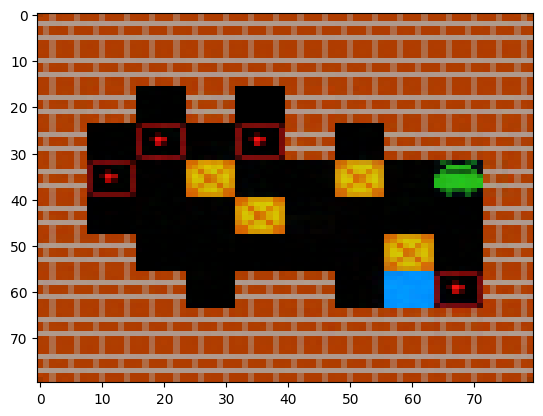

In [3]:
b = -1
state = env.reset()
util.plot_raw_state(state["xs"][b])
util.plot_raw_state(state["real_states"][b])
pred_state = torch.clamp(decoder(state["xs"])/255, 0, 1).float()
util.plot_raw_state(pred_state[b])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


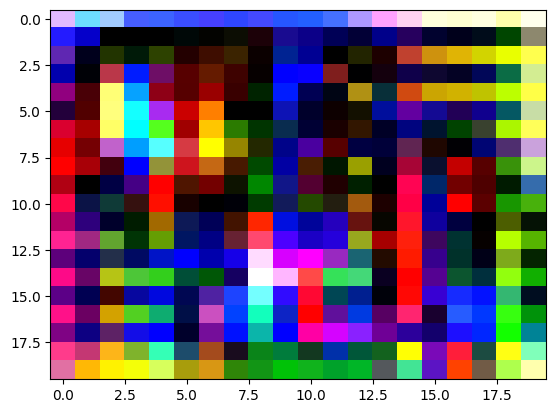

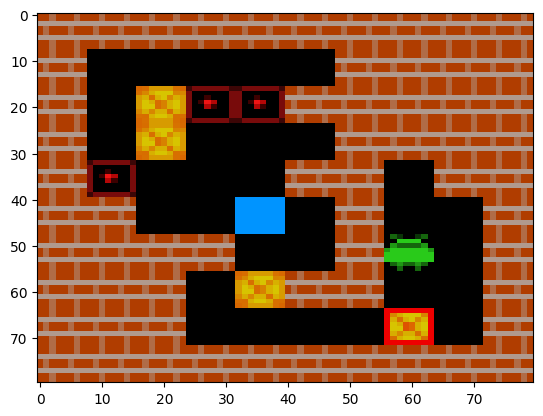

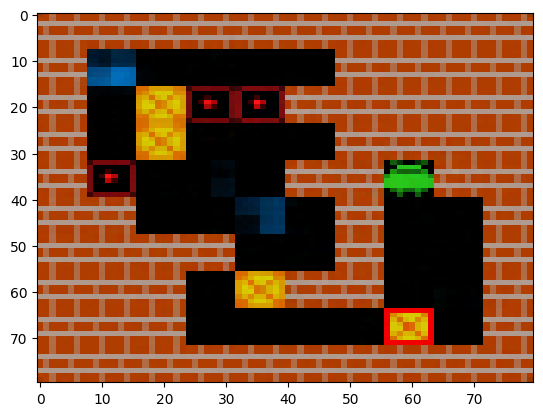

In [102]:
pri_action = torch.full((env_n,), fill_value=1, device=device, dtype=torch.long)
reset_action = torch.full((env_n,), fill_value=0, device=device, dtype=torch.long)
state, reward, done, info = env.step(pri_action, reset_action, ignore=True)
util.plot_raw_state(state["xs"][b])
util.plot_raw_state(state["real_states"][b])
pred_state = torch.clamp(decoder(state["xs"])/255, 0, 1).float()
util.plot_raw_state(pred_state[b])

In [38]:
pred_state[0].shape

torch.Size([3, 80, 80])

In [39]:
state["real_states"][b].shape

torch.Size([3, 80, 80])